## Problema 2

In [230]:
import numpy as np
import matplotlib.pyplot as plt
from dataset import *
from sklearn.linear_model import LinearRegression as LR
import functools

In [231]:
X_simple,t_simple = simple_dataset(noise=5,n_samples=300)

## feature normalisation

# X_simple = X_simple / X_simple.max()

division_ratio = 0.8
split_point =int(division_ratio * len(X_simple)) 

X_train_simple = X_simple[:split_point]
X_test_simple = X_simple[split_point:]

t_train_simple = t_simple[:split_point]
t_test_simple = t_simple[split_point:]

print(type(X_simple))

<class 'numpy.ndarray'>


### Ridge regression

#### Matricea aia e inversabila | poti si forma completa si forma cu gradient descent

In [232]:
def shuffle_data(X,t,shuffle=True):
    '''
    X - N x d
    t - N x _
    '''
    data = np.hstack((X,t[:,np.newaxis]))
    if shuffle:
        np.random.shuffle(data)
    new_X = data[:,:-1]
    new_t = data[:,-1]

    return new_X,new_t

In [233]:
class RidgeRegression():

    def __init__(self,alpha=1):
        self.alpha = alpha

    def fit(self, X, t):

        N, D = X.shape
        X_t = np.transpose(X)
        self.w = np.linalg.inv(X.T @ X + self.alpha * np.identity(X.shape[1])) @ X.T @ t

    def predict(self, X, return_std=False):

        N, D = X.shape

        y = X @ self.w
        # print(X.shape,y.shape,"IN predict")
        
        if return_std:

            y_std = np.sqrt(self.var) 

            return y, y_std
        return y

In [234]:
class LinearRegression(object):

    def __init__(self, learning_rate=0.01, epochs=300, eps=1e-6,alpha=0.0001):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.eps = eps
        self.alpha = alpha
        ## [(epoch,error)]
        self.errors = []

    def fit(self, X, t):

        N, D = X.shape
        
        self.w = np.zeros(D)
        prev_w = self.w 
        prev_cost = self.cost(X,t)

        for ep in range(self.epochs):
            g = self.gradient(X,t)
            step = self.learning_rate * g
            self.w = self.w - step
            
            prev_cost = self.cost(X,t)

            self.errors += [(ep,prev_cost)]

            if np.linalg.norm(self.w - prev_w) < self.eps:
               
                break

            prev_w = self.w



        # return self

    def predict(self, X, return_std=False):
        N, D = X.shape
        y = X @ self.w 
        return y

    
    ## Not 1 / n 
    def cost(self,X,t,return_std=False):
        y = self.predict(X,return_std)
        loss = (y - t) ** 2
        # return 0.5 * loss
        return np.mean(loss)

    def gradient(self,X,t):
        y = self.predict(X)
        d_bias =  -2*sum(t - y)
        d_w = -2*sum(X[:,1:] * (t - y).reshape(-1,1))
        g = np.append(np.array(d_bias), d_w) 
        return g / X.shape[0] + self.alpha * self.w
        # return g / 2 

In [235]:
def mean_squared_error(y, t):
    return np.mean((y - t) * (y- t))

def normalised_squared_error(y,t):
    return np.mean((y - t) / t.max()  * (y- t) / t.max())

def RMSE(y,t):
    return np.sqrt(mean_squared_error(y,t))

def NRMSE(y,t):
    return RMSE(y,t) / (np.max(t) - np.min(t))

In [236]:
def extract_polynomial_features(X, M):
    phi = X
    return np.array([x ** np.arange(M + 1) for x in phi])

In [237]:
def ten_fold_validation(X,t,model,shuffle=False):
    
    new_X,new_t = shuffle_data(X,t,shuffle=shuffle)
    data = np.hstack((new_X,new_t[:,np.newaxis]))
    splitted_data = np.split(data,10)
    errors = []

    for i in range(10):
        ## i is the test set 
        X_test = splitted_data[i][:,:-1]
        t_test = splitted_data[i][:,-1]

        not_init = True
        train_data = None
        for j in range(10):
            if j != i:
                if not_init:
                    train_data = splitted_data[j]
                    not_init = False
                else:
                    train_data = np.vstack((train_data,splitted_data[j]))

        
        X_train = train_data[:,:-1]
        t_train = train_data[:,-1]

        X_train_feat = extract_polynomial_features(X_train,1)
        X_test_feat = extract_polynomial_features(X_test,1)

        model.fit(X_train_feat,t_train)
        y = model.predict(X_test_feat)
        errors += [mean_squared_error(y,t_test)]
        

    return errors



Mean MSE: 26.91068981026533


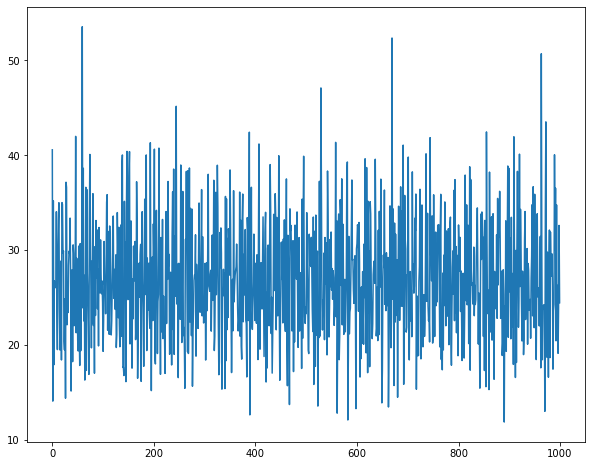

In [242]:
errors = []
mean_errors = []
for i in range(100):
    errors += ten_fold_validation(X_simple,t_simple,LinearRegression(),shuffle=True)



print("Mean MSE:",np.mean(errors))
fig = plt.figure(figsize=(10, 8))
plt.scatter([i for i in range(1000)],errors)
plt.show()



In [246]:
alphas = np.linspace(0.001,1,20)

chosen_alphas = {}

for alpha in alphas:
    chosen_alphas[alpha] = 0

for i in range(10):
    min_error = 1e6
    winner_alpha = 1e6
    for alpha in alphas:
        model = RidgeRegression(alpha=alpha)
        err = np.mean(ten_fold_validation(X_simple,t_simple,model,shuffle=True))

        print("Alpha:",alpha," Mean error:",err)

        if err < min_error:
            min_error = err
            winner_alpha = alpha

    chosen_alphas[winner_alpha] += 1

print(chosen_alphas)
    

Alpha: 0.001  Mean error: 26.872848886639567
Alpha: 0.05357894736842105  Mean error: 26.831492557838335
Alpha: 0.1061578947368421  Mean error: 26.947294036701486
Alpha: 0.15873684210526315  Mean error: 26.999828232387777
Alpha: 0.2113157894736842  Mean error: 27.002086266229583
Alpha: 0.26389473684210524  Mean error: 26.893062121325176
Alpha: 0.3164736842105263  Mean error: 26.77484842384478
Alpha: 0.36905263157894735  Mean error: 27.282515523419157
Alpha: 0.4216315789473684  Mean error: 26.68262788066812
Alpha: 0.47421052631578947  Mean error: 26.880450508696867
Alpha: 0.5267894736842105  Mean error: 26.80317499587058
Alpha: 0.5793684210526315  Mean error: 26.91180565690636
Alpha: 0.6319473684210526  Mean error: 26.897781679546874
Alpha: 0.6845263157894736  Mean error: 26.92377289372454
Alpha: 0.7371052631578947  Mean error: 27.09959723870611
Alpha: 0.7896842105263158  Mean error: 26.711367021152142
Alpha: 0.8422631578947368  Mean error: 26.91881368511205
Alpha: 0.8948421052631579  Me